In [2]:
import numpy as np
import pandas as pd
import Surfaces
from Giotto2Mapper import two_dim_nerve, two_mapper
import plotly.graph_objects as go
import plotly
import igraph

In [3]:
from gtda.mapper import (
    CubicalCover,
    make_mapper_pipeline,
    Projection,
    plot_static_mapper_graph,
    plot_interactive_mapper_graph,
    MapperInteractivePlotter,
    nerve,
    FirstHistogramGap
)
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from functools import reduce
from LatticeCover import LatticeCover

In [29]:
data = Surfaces.sample_torus(5000)
pipe = make_mapper_pipeline(
    filter_func = Projection(columns = [0,1,2]),
    cover = LatticeCover(),
    clusterer = DBSCAN(),
    verbose = True,
    store_edge_elements = True
)
filter = Projection(columns = [0,1])
cover = LatticeCover()

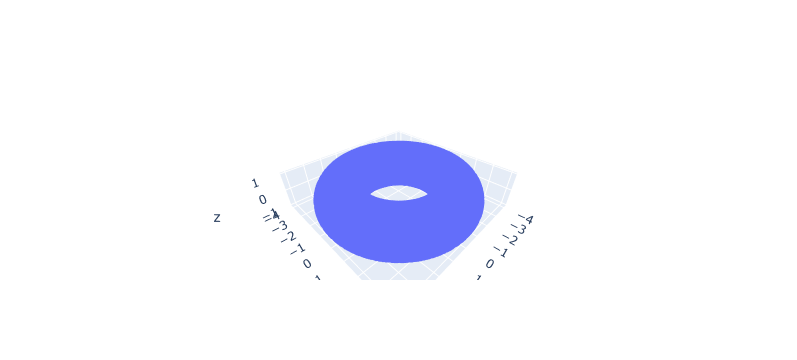

In [27]:
Surfaces.graph_sample(data)

In [4]:
fit_data = filter.fit_transform(data)
fit_data.shape

(100, 2)

In [5]:
cov_data = cover.fit_transform(fit_data)
cov_data.shape

(100, 82)

In [6]:
len(fit_data) == len(cov_data)

True

In [11]:
graph = pipe.fit_transform(data)

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.2s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.4s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


In [8]:
len(graph.list_triangles())

65

In [9]:
simplex_list = Giotto2Mapper.two_dim_nerve(graph)

In [10]:
simplex_list

[[igraph.Vertex(<igraph.Graph object at 0x7f53957e3940>, 1, {'pullback_set_label': 57, 'partial_cluster_label': -1, 'node_elements': array([1])}),
  igraph.Vertex(<igraph.Graph object at 0x7f53957e3940>, 2, {'pullback_set_label': 58, 'partial_cluster_label': -1, 'node_elements': array([ 1, 12])}),
  igraph.Vertex(<igraph.Graph object at 0x7f53957e3940>, 3, {'pullback_set_label': 65, 'partial_cluster_label': -1, 'node_elements': array([ 1, 25])})],
 [igraph.Vertex(<igraph.Graph object at 0x7f53957e3940>, 4, {'pullback_set_label': 34, 'partial_cluster_label': -1, 'node_elements': array([2])}),
  igraph.Vertex(<igraph.Graph object at 0x7f53957e3940>, 5, {'pullback_set_label': 45, 'partial_cluster_label': -1, 'node_elements': array([ 2, 65])}),
  igraph.Vertex(<igraph.Graph object at 0x7f53957e3940>, 6, {'pullback_set_label': 47, 'partial_cluster_label': -1, 'node_elements': array([2, 4])})],
 [igraph.Vertex(<igraph.Graph object at 0x7f53957e3940>, 6, {'pullback_set_label': 47, 'partial_cl

In [19]:
from itertools import combinations, compress
from functools import reduce
from operator import iconcat
import warnings
from gtda.mapper.utils._visualization import _get_colors_for_vals

In [6]:
def list_2simplices(graph, intersection_data = False):
    node_triples = graph.list_triangles()
    num_triples = len(node_triples)
    simplex_list = [None] * (num_triples+1)
    simplex_mask = [False] * (num_triples+1)
    intersections = np.zeros(num_triples)
    for i, triple in enumerate(node_triples):
        intersection = reduce(np.intersect1d, 
                              graph.vs[triple]['node_elements']
                             )
        if len(intersection) > 0:
            simplex_mask[i] = True
            simplex_list[i] = triple
            if intersection_data:
                intersections[i] = len(intersection)
    simplex_list = list(compress(simplex_list, simplex_mask))
    if intersection_data:
        nonzero_intersections = intersections[intersections > 0]
        return simplex_list, nonzero_intersections
    if intersection_data is False:
        return simplex_list

In [17]:
def new_two_mapper(fancy_edges = False, fancy_simplices = False, **mapper_figure_dict):
    if mapper_figure_dict['layout_dim'] != 3:
        raise ValueError("layout_dim must equal 3 to produce 2Mapper graph")
    graph = mapper_figure_dict['pipeline'].fit_transform(data)
    figure = plot_static_mapper_graph(**mapper_figure_dict)
    # Fancy edges makes the graph look clunky
    if fancy_edges is True:
        warnings.warn('fancy_edges can cause visually clunky graphs. Proceed with caution.', RuntimeWarning)
        edge_weights = dict(list())
        for i,weight in enumerate(graph.es['weight']):
            if weight not in edge_weights.keys():
                edge_weights[weight] = [i]
            else:
                edge_weights[weight].append(i)             
    if fancy_simplices is True:
        simplex_list, simplex_intersections = list_2simplices(graph, intersection_data = True)
        opacities = dict(list())
        for intersection_value in set(simplex_intersections):
            if intersection_value not in opacities.keys():
                simplices = np.argwhere(
                    np.asarray(simplex_intersections) == intersection_value
                )
                opacities[intersection_value] = list(simplices.reshape(len(simplices),))
            else:
                continue
    if fancy_simplices is False:         
        simplex_list = list_2simplices(graph)
        num_simplices = len(simplex_list)
        i = np.full(num_simplices, -1)
        j = np.full(num_simplices, -1)
        k = np.full(num_simplices, -1)
        for x in range(num_simplices):
            i[x] = simplex_list[x][0]
            j[x] = simplex_list[x][1]
            k[x] = simplex_list[x][2]
    node_pos = np.asarray(graph.layout(mapper_figure_dict['layout'], dim = 3).coords)   
    node_colors = figure.data[1].marker.color
    node_colorscale = figure.data[1].marker.colorscale
    face_color_vals = _get_simplex_colors(node_colors, simplex_list)
    face_colors = _get_colors_for_vals(face_color_vals,
                                   vmin = np.min(node_colors),
                                   vmax = np.max(node_colors),
                                   colorscale = node_colorscale,
                                   return_hex = True)
    if ((fancy_simplices is True) and (fancy_edges is True)):
        fancy_figure = plotly.graph_objects.FigureWidget(layout = figure.layout)
        
        # We first want to add the 2-simplicies with varying opacities
        for opacity in opacities:
            f = _opacity_trace(opacity, opacities, simplex_list, node_pos, face_colors, node_colorscale)
            fancy_figure.add_trace(f)
        # We then add the edges with varying line weights
        # Note we cannot change the color of each edge due to limitations 
        # in Plotly.
        # If we wanted to do this we would need a trace for each edge color.
        for weight in edge_weights:
            f = _lineweight_trace(weight, edge_weights, figure)
            fancy_figure.add_trace(f)

        # Add the node trace from the original figure
        fancy_figure.add_trace(figure.data[1])
        return fancy_figure
    
    elif ((fancy_simplices is True) and (fancy_edges is False)):
        fancy_figure = plotly.graph_objects.FigureWidget(layout = figure.layout)
        for opacity in opacities:
            f = _opacity_trace(opacity, opacities, simplex_list, node_pos, face_colors, node_colorscale)
            fancy_figure.add_trace(f)
        fancy_figure.add_traces([figure.data[0], figure.data[1]])
        return fancy_figure
    
    elif ((fancy_simplices is False) and (fancy_edges is True)):
        fancy_figure = plotly.graph_objects.FigureWidget(layout = figure.layout)
        for weight in edge_weights:
            f = _lineweight_trace(weight, edge_weights, figure)
            fancy_figure.add_trace(f)
        simplex_trace = plotly.graph_objects.Mesh3d(
            x=node_pos[:,0], y=node_pos[:,1], z=node_pos[:,2],
            i=i, j=j, k=k,
            facecolor = face_colors, 
            colorscale = node_colorscale,
            name = 'simplex_trace',
            legendrank = 2000
        )
        fancy_figure.add_traces([simplex_trace, figure.data[1]])
        return fancy_figure
        
    else:
        figure.add_mesh3d(x=node_pos[:,0], y=node_pos[:,1], z=node_pos[:,2],
                          i=i, j=j, k=k,
                          facecolor = face_colors, 
                          colorscale = node_colorscale,
                          name = 'simplex_trace',
                          legendrank = 2000
                         )
        return figure
        
def _lineweight_trace(weight, edge_weights, figure):
    f = dict()
    f['hoverinfo'] = 'none'
    f['mode'] = 'lines'
    f['line'] = {'color': '#888',
                 'width': weight} 
    f['name'] = f'edge_trace_weight_{weight}'
    f['legendrank'] = 1500
    f['x'] = list()
    f['y'] = list()
    f['z'] = list()
    for edge in edge_weights[weight]:
        f['x'].extend(figure.data[0]['x'][3*edge:3*edge+3])
        f['y'].extend(figure.data[0]['y'][3*edge:3*edge+3])
        f['z'].extend(figure.data[0]['z'][3*edge:3*edge+3])
    return plotly.graph_objects.Scatter3d(f)

def _opacity_trace(opacity, opacities, simplex_list, node_pos, face_colors,
                   node_colorscale):  
    f = dict()
    f['i'] = np.full(len(opacities[opacity]), -1)
    f['j'] = np.full(len(opacities[opacity]), -1)
    f['k'] = np.full(len(opacities[opacity]), -1)
    f['facecolor'] = ['a'] * int(len(opacities[opacity]))
    for i, x in enumerate(opacities[opacity]):
        f['i'][i] = simplex_list[x][0]
        f['j'][i] = simplex_list[x][1]
        f['k'][i] = simplex_list[x][2]
        f['facecolor'][i] = face_colors[x]
    f['x'] = node_pos[:,0]
    f['y'] = node_pos[:,1]
    f['z'] = node_pos[:,2]
    f['colorscale'] = node_colorscale
    f['name'] = f'simplex_trace_opacity_{opacity}'
    if len(opacities) > 1:
        f['opacity'] = float((opacity-min(opacities))/(max(opacities)-min(opacities)))
    if len(opacities) == 1:
        f['opacity'] = 1
    f['legendrank'] = 2000                     
    return plotly.graph_objects.Mesh3d(f)

def _get_simplex_colors(node_colors, simplex_list):
    face_color_vals = np.full(len(simplex_list), -1)
    for i, x in enumerate(simplex_list):
        face_color_vals[i] = np.mean(
            [node_colors[x[0]],
            node_colors[x[1]],
            node_colors[x[2]]]
        )
    return face_color_vals

In [8]:
import time

In [12]:
s = time.time()
print(len(list_2simplices(graph)))
e = time.time()
print(e-s)

71
0.014095544815063477


In [13]:
s = time.time()
print(len(two_dim_nerve(graph)))
e = time.time()
print(e-s)

71
1.771960735321045


In [15]:
len(graph.list_triangles())

72

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.6s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.6s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.4s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   1.1s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.6s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.6s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.4s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   1.1s


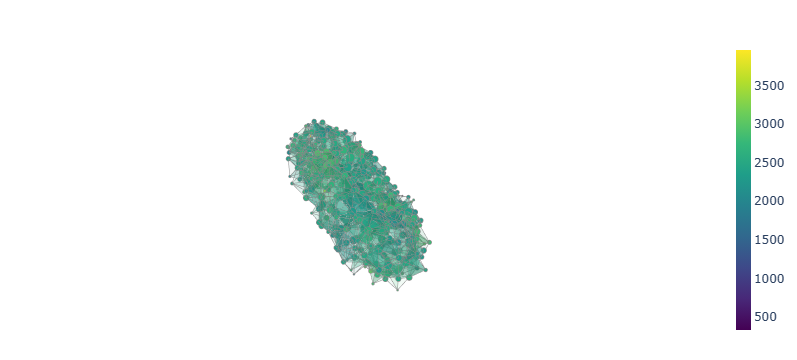

In [30]:
mapper_dict = {'pipeline': pipe, 'data' : data, 'layout' : 'kk3d', 'layout_dim' : 3, 'node_scale' : 25 }
g = new_two_mapper(fancy_simplices = True, **mapper_dict)
g.show()

In [32]:
from gtda.mapper import plot_interactive_mapper_graph

In [40]:
plot_interactive_mapper_graph(pipe, data, layout_dim = 3, layout = 'kk3d', color_data= data, node_scale = 30)

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   1.3s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   1.4s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   1.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   2.3s
